# Code to compute Gaussian and Gauss + SSC covariance matrices for WL, GCph and 3x2pt
D. Sciotti, M. Bonici

Inputs needed: 
* $\ell$ and $\Delta \ell$ values
* $C_{ij}^{AB}(\ell)$ for WL-WL, GCph-GCph and WL-GCph ("XC")
* $W_i^A(z)$ for WL and GCph (needed for __SSC__)

Outputs (for WL only, GCph only and 3x2pt): 
* Gaussian covariance
* Gauss + SSC covariance

Code can be easily extended to:
* different no. of $z$ bins
* different no. of $\ell$ bins
* different $\ell$ ranges (e.g. intermediate, pessimistic case)

# Step 1: compute Gaussian covariance

Gaussian covariance:
$$Cov[C^{AB}_{ij}(\ell),C^{A'B'}_{kl}(\ell ')] = \left[ \dfrac{[C^{AA'}_{ik}(\ell) + N^{AA'}_{ik}(\ell)][C^{BB'}_{jl}(\ell ') + N^{BB'}_{jl}(\ell ')] + [C^{AB'}_{il}(\ell) + N^{AB'}_{il}(\ell)][C^{BA'}_{jk}(\ell ') + N^{BA'}_{jk}(\ell ')]}{(2\ell +1)f_{sky}\Delta \ell}  \right]\delta^K_{ \ell \ell '}$$

In [50]:
import math ; pi=math.pi
import matplotlib.cm as cm
import numpy as np
import scipy.integrate as integrate
from numba import jit
import matplotlib.pyplot as plt
import time
from pathlib import Path
import sys
import PySSC

path = Path.cwd().parent # get project directory

# import configuration and functions modules
sys.path.append(str(path / 'config'))
import my_config
sys.path.append(str(path / 'lib'))
import my_module as mm

In [51]:
plt.rcParams["figure.figsize"] = (16,9)
#plt.rcParams["uselatex"] = True

params = {'lines.linewidth' : 3,
          'font.size' : 17,
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large',
          # 'mathtext.fontset': 'stix',
          # 'font.family': 'STIXGeneral'
          }

plt.rcParams.update(params)
markersize = 10

### Specify no. of $z$ bins, $(\ell_{min},\ell_{max})$ for the diffferent probes, no. of $\ell$ bins
Note: in the 3x2pt case we're taking the WL probe up to $\ell_{max} = \ell_{max}^{GC}$, then we compute a separate covariance matrix taking only the excess bins from $\ell_{max}^{GC}$ to $\ell_{max}^{WL}$ (__WA__, for "WL-add")

In [52]:
zbins   = my_config.zbins
nbl = my_config.nbl
Cij_folder = my_config.Cij_folder

ell_min = my_config.ell_min
ell_max_WL = my_config.ell_max_WL
ell_max_GC = my_config.ell_max_GC
ell_max_XC = ell_max_GC
ell_max_WA = ell_max_GC 

nProbes = my_config.nProbes

survey_area = 15000 # deg^2
deg2_in_sphere = 41252.96 # deg^2 in a spere
fsky = survey_area/deg2_in_sphere

# redshift pairs
npairs  = int((zbins*(zbins+1))/2) # = 55, cast it as int
npairs_asimm = zbins**2
npairs_tot = 2*npairs + npairs_asimm
    
print(f"check: \nzbins = {zbins} \nnbl = {nbl} \nell_max_WL = {ell_max_WL} \nell_max_GC = {ell_max_GC} \nfsky = {fsky}")

check: 
zbins = 10 
nbl = 30 
ell_max_WL = 5000 
ell_max_GC = 3000 
fsky = 0.3636102718447355


### The "ind" array maps indices of 2D matrix into indices of pairs: $C_{ij}(\ell) \leftrightarrow C_{p}(\ell)$

In [53]:
# indices array
ind = np.genfromtxt(path / "inputs/indici.dat")
ind = ind.astype(int)
ind = ind - 1 

In [61]:
print('  A,B,i,j\n')
print(ind)

  A,B,i,j

[[0 0 0 0]
 [0 0 1 0]
 [0 0 1 1]
 [0 0 2 0]
 [0 0 2 1]
 [0 0 2 2]
 [0 0 3 0]
 [0 0 3 1]
 [0 0 3 2]
 [0 0 3 3]
 [0 0 4 0]
 [0 0 4 1]
 [0 0 4 2]
 [0 0 4 3]
 [0 0 4 4]
 [0 0 5 0]
 [0 0 5 1]
 [0 0 5 2]
 [0 0 5 3]
 [0 0 5 4]
 [0 0 5 5]
 [0 0 6 0]
 [0 0 6 1]
 [0 0 6 2]
 [0 0 6 3]
 [0 0 6 4]
 [0 0 6 5]
 [0 0 6 6]
 [0 0 7 0]
 [0 0 7 1]
 [0 0 7 2]
 [0 0 7 3]
 [0 0 7 4]
 [0 0 7 5]
 [0 0 7 6]
 [0 0 7 7]
 [0 0 8 0]
 [0 0 8 1]
 [0 0 8 2]
 [0 0 8 3]
 [0 0 8 4]
 [0 0 8 5]
 [0 0 8 6]
 [0 0 8 7]
 [0 0 8 8]
 [0 0 9 0]
 [0 0 9 1]
 [0 0 9 2]
 [0 0 9 3]
 [0 0 9 4]
 [0 0 9 5]
 [0 0 9 6]
 [0 0 9 7]
 [0 0 9 8]
 [0 0 9 9]
 [1 0 0 0]
 [1 0 0 1]
 [1 0 0 2]
 [1 0 0 3]
 [1 0 0 4]
 [1 0 0 5]
 [1 0 0 6]
 [1 0 0 7]
 [1 0 0 8]
 [1 0 0 9]
 [1 0 1 0]
 [1 0 1 1]
 [1 0 1 2]
 [1 0 1 3]
 [1 0 1 4]
 [1 0 1 5]
 [1 0 1 6]
 [1 0 1 7]
 [1 0 1 8]
 [1 0 1 9]
 [1 0 2 0]
 [1 0 2 1]
 [1 0 2 2]
 [1 0 2 3]
 [1 0 2 4]
 [1 0 2 5]
 [1 0 2 6]
 [1 0 2 7]
 [1 0 2 8]
 [1 0 2 9]
 [1 0 3 0]
 [1 0 3 1]
 [1 0 3 2]
 [1 0 3 3]
 [1 0 3 4]

### Load $\ell$ and $\Delta\ell$ values from previous script


In [62]:
# import ell values
ell_WL = np.genfromtxt(f"{path}/inputs/ell_values/ell_WL_ellMaxWL{ell_max_WL}_nbl{nbl}.txt")
ell_GC = np.genfromtxt(f"{path}/inputs/ell_values/ell_GC_ellMaxGC{ell_max_GC}_nbl{nbl}.txt")
ell_WA = np.genfromtxt(f"{path}/inputs/ell_values/ell_WA_ellMaxWA{ell_max_WA}_nbl{nbl}.txt")

# nbl for Wadd
if ell_WA.size == 1: # in the case of just one bin it would give error
    nbl_WA = 1
else:
    nbl_WA = ell_WA.shape[0]

# and deltas
l_lin_WL = 10**ell_WL
l_lin_GC = 10**ell_GC
l_lin_WA = 10**ell_WA
l_lin_XC = l_lin_GC

delta_l_WL = np.genfromtxt(f"{path}/inputs/ell_values/delta_l_WL_ellMaxWL{ell_max_WL}_nbl{nbl}.txt")
delta_l_GC = np.genfromtxt(f"{path}/inputs/ell_values/delta_l_GC_ellMaxGC{ell_max_GC}_nbl{nbl}.txt")
delta_l_WA = np.genfromtxt(f"{path}/inputs/ell_values/delta_l_WA_ellMaxWA{ell_max_WA}_nbl{nbl}.txt")
delta_l_XC = delta_l_GC # ALL

### Import $C_{ij}(\ell)$

In [64]:
C_LL = np.load(path / f"inputs/cl/C_LL_nbl{nbl}_lmaxWL{ell_max_WL}_3D.npy")
C_GG = np.load(path / f"inputs/cl/C_GG_nbl{nbl}_lmaxGC{ell_max_GC}_3D.npy")
C_WA = np.load(path / f"inputs/cl/C_WA_nbl{nbl}_lmaxWL{ell_max_WL}_3D.npy")

# datavector (ALL)
D_ALL = np.load(path / f"inputs/cl/D_ALL_nbl{nbl}_lmaxWL{ell_max_WL}_5D.npy")

print('C_LL and C_GG shape:', C_LL.shape)
print('3x2pt datavector shape:', D_ALL.shape)


C_LL and C_GG shape: (30, 10, 10)
3x2pt datavector shape: (30, 2, 2, 10, 10)


### Define noise terms:
$$N^{LL}_{ij}(\ell) = \dfrac{\sigma_\epsilon^2}{\bar{n}}\delta^K_{ij}$$

$$N^{GG}_{ij}(\ell) = \dfrac{1}{\bar{n}}\delta^K_{ij}$$

$$N^{LG}_{ij}(\ell) = N^{GL}_{ij}(\ell) = 0$$

In [65]:
# parameters needed
sigma_eps2 = 0.09
ng = 30 # number of galaxies per arcmin^2 (constant)
conversion_factor = 11818102.860035626 # deg to arcmin^2
fraction = 1/zbins
n_bar = ng*conversion_factor*fraction

# create the arrays
N_LL = np.zeros((zbins, zbins))
N_GG = np.zeros((zbins, zbins))
N_LG = 0
N    = np.zeros((nProbes, nProbes, zbins, zbins))

# fill the arrays
for i in range(zbins):
    for j in range(zbins):
        if (i==j):
            N_LL[i,j] = (sigma_eps2)/n_bar
            N_GG[i,j] = 1/n_bar
        else:
            N_LL[i,j] = 0
            N_GG[i,j] = 0
# symmetrize
for i in range(zbins):
    for j in range(zbins):
        N[0,0,i,j] = N_LL[i,j]
        N[1,1,i,j] = N_GG[i,j]

### Compute Gaussian Covariance for all probes

### Function for 3x2pt (use `@jit`! http://numba.pydata.org/)

<br>
$$Cov[C^{AB}_{ij}(\ell),C^{A'B'}_{kl}(\ell ')] = \left[ \dfrac{[C^{AA'}_{ik}(\ell) + N^{AA'}_{ik}(\ell)][C^{BB'}_{jl}(\ell ') + N^{BB'}_{jl}(\ell ')] + [C^{AB'}_{il}(\ell) + N^{AB'}_{il}(\ell)][C^{BA'}_{jk}(\ell ') + N^{BA'}_{jk}(\ell ')]}{(2\ell +1)f_{sky}\Delta \ell}  \right]\delta^K_{ \ell \ell '}$$

In [66]:
# function for 3x2pt

@jit(nopython=True)
def covariance_ALL(nbl, npairs, Cij, noise, l_lin, delta_l, fsky, ind):
    
    # create covariance array
    cov_GO = np.zeros((nbl, nbl, npairs, npairs))
    
    # compute cov(ell, p, q)
    for ell in range(nbl):
        for p in range(npairs):
            for q in range(npairs):

                # ind carries info about both the probes and the z indices!
                A, B, C, D = ind[p, 0], ind[p, 1], ind[q, 0], ind[q, 1]
                i, j, k, l = ind[p, 2], ind[p, 3], ind[q, 2], ind[q, 3]

                cov_GO[ell, ell, p, q] = \
                    ((Cij[ell, A, C, i, k] + noise[A, C, i, k]) * (Cij[ell, B, D, j, l] + noise[B, D, j, l]) +
                     (Cij[ell, A, D, i, l] + noise[A, D, i, l]) * (Cij[ell, B, C, j, k] + noise[B, C, j, k])) / \
                    ((2 * l_lin[ell] + 1) * fsky * delta_l[ell])
                
    return cov_GO

In [67]:
start_time = time.time()

# WL only covariance
cov_WL_Gauss = mm.covariance(nbl = nbl, npairs = npairs, start_index = 0, stop_index = npairs,
                             Cij = C_LL, noise = N, l_lin = l_lin_WL,
                             delta_l = delta_l_WL, fsky = fsky, ind = ind)
# GC only covariance
starting_GC_index = npairs + npairs_asimm
cov_GC_Gauss = mm.covariance(nbl = nbl, npairs = npairs, start_index = starting_GC_index, stop_index = npairs_tot,
                             Cij = C_GG, noise = N, l_lin = l_lin_GC,
                             delta_l = delta_l_GC, fsky = fsky, ind = ind)
# ALL covariance
cov_ALL_Gauss = mm.covariance_ALL(nbl = nbl, npairs = npairs_tot,
                                  Cij = D_ALL, noise = N, l_lin = l_lin_XC,
                                  delta_l = delta_l_XC, fsky = fsky, ind = ind)

# WA covariance
cov_WA_Gauss = mm.covariance_WA(nbl_WA, npairs, start_index = 0, stop_index = npairs,
                                Cij = C_WA, noise = N, l_lin = l_lin_WA,
                                delta_l = delta_l_WA, fsky = fsky, ind = ind, ell_WA = ell_WA)

print("Gaussian covariance matrices computed in %.2f seconds" %(time.time() - start_time))

Gaussian covariance matrices computed in 0.19 seconds


### Save matrices

In [76]:
np.save(path / f"outputs/covmat/covmat_WL_lmaxWL{ell_max_WL}_nbl{nbl}.npy", cov_WL_Gauss)
np.save(path / f"outputs/covmat/covmat_GC_lmaxGC{ell_max_GC}_nbl{nbl}.npy", cov_GC_Gauss)
np.save(path / f"outputs/covmat/covmat_ALL_lmaxXC{ell_max_XC}_nbl{nbl}.npy", cov_ALL_Gauss)
np.save(path / f"outputs/covmat/covmat_WA_lmaxWL{ell_max_WL}_nbl{nbl}.npy", cov_WA_Gauss)
print('saved')

saved


In [69]:
import os
size_B_3x2pt = os.path.getsize(path / f"outputs/covmat/covmat_ALL_lmaxXC{ell_max_XC}_nbl{nbl}.npy")
size_B_WL = os.path.getsize(path / f"outputs/covmat/covmat_WL_lmaxWL{ell_max_WL}_nbl{nbl}.npy")
size_MB_3x2pt = size_B_3x2pt/1e6
size_MB_WL = size_B_WL/1e6

print(f'size of the 3x2pt Gauss-only covariance matrix: {size_MB_3x2pt:.2f} MB (nbl = {nbl}, zbins = {zbins})')
print(f'size of the WL Gauss-only covariance matrix:    {size_MB_WL:.2f} MB  (nbl = {nbl}, zbins = {zbins})\n')

print('3x2pt covariance shape:', cov_ALL_Gauss.shape)
print('WL covariance shape:', cov_WL_Gauss.shape)

size of the 3x2pt Gauss-only covariance matrix: 317.52 MB (nbl = 30, zbins = 10)
size of the WL Gauss-only covariance matrix:    21.78 MB  (nbl = 30, zbins = 10)

3x2pt covariance shape: (30, 30, 210, 210)
WL covariance shape: (30, 30, 55, 55)


# Step 2: compute SS covariance

### Fast SSC: (Lacasa & Grain, arXiv:1809.05437):

Approximation used: the response of the probe, which amounts how a given probe varies with changes of the background density $\delta_b$, vary slowly with redshift compared to $\sigma^2(z_1,z_2)$ 

<br>
$$Cov_{G+SSC} = Cov_{G} + Cov_{SSC}$$
<br>
$$    Cov_{SSC}[C^{AB}_{ij}(\ell),C^{CD}_{kl}(\ell ')] \simeq R^{AB}(\ell)C^{AB}_{ij}(\ell)R^{CD}(\ell)C^{CD}_{kl}(\ell ')S^{A,B;C,D}_{i,j;k,l} \times f_{sky}^{-1} $$

With:
* $ R^{AB}(\ell)$: effective relative response of the PS between probes A and B to a change in bg density (taken constant = 4)
* $S^{A,B;C,D}_{i,j;k,l}$ (from here on $S_{ijkl}$): dimensionless volume-averaged (co)variance of the background matter density contrast

$$S_{i_{z}, j_{z} ; k_{z}, l_{z}}^{A, B ; C, D}=\int \mathrm{d} V_{1} \mathrm{~d} V_{2} \frac{W_{i_{z}}^{A}\left(z_{1}\right) W_{j_{z}}^{B}\left(z_{1}\right)}{I^{A B}\left(i_{z}, j_{z}\right)} \frac{W_{k_{z}}^{C}\left(z_{2}\right) W_{l_{z}}^{D}\left(z_{2}\right)}{I^{C D}\left(k_{z}, l_{z}\right)} \sigma^{2}\left(z_{1}, z_{2}\right)$$

* $\text d V = \chi^2(z) \frac{\text d \chi }{ \text d z} \text d z$ comoving volume per steradian
* $\sigma^2(z_1,z_2)$: change in the background density 
on a given survey volume due to 
super-survey modes modulations 


$$\sigma^2(z_1,z_2) = \dfrac{1}{2\pi^2}\int
k^2\text {d} k P_m(k|z_{12})j_0(k\chi_1)j_0(k\chi_2)$$

* $I^{AB}(i_z,j_z)$: normalization factor

$$    I^{AB}(i_z,j_z)= \int \mathrm{d} V_1 W^A_{i_z}(z_1) W^B_{j_z}(z_1)$$

## 2.1: Compute $S_{ijkl}$

### Define $S_{ijkl}$ routine (from PySSC: [GitHub](https://github.com/fabienlacasa/PySSC), [readthedocs](https://pyssc.readthedocs.io/en/latest/), [paper](https://arxiv.org/abs/1809.05437))

(need to install `classy`, the Python wrapper for `CLASS` (install from [GitHub](https://github.com/lesgourg/class_public) or with `pip install classy` command)


**No need to re-compute $S_{ijkl}$ for varying $\ell$ range and/or no. of $\ell$ bins**

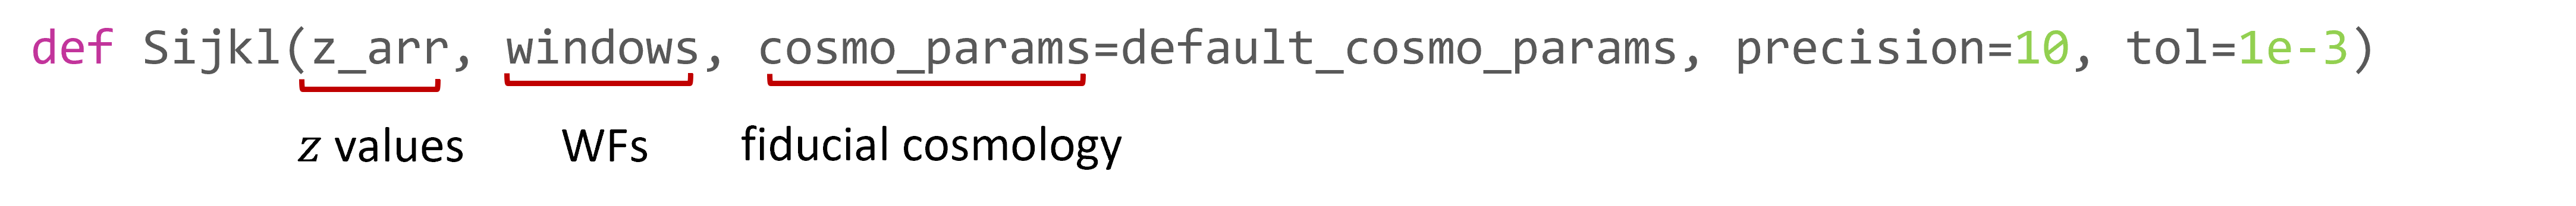

__3 inputs needed for Sijkl:__
* fiducial cosmological parameters vector (in the form of a dictionary)
* Window functions $W^A_i(z)$
* corresponding $z$ values

### Choose fiducial cosmology

In [70]:
Omega_b = 0.05
Omega_m = 0.32
h       = 0.67
n_s     = 0.96
sigma8  = 0.816

# neutrinos
m_ncdm  = 0.06
N_ncdm = 1
N_ur   = 2.03351
Omega_ni  = m_ncdm/(93.14*h*h)

# DE
Omega_Lambda = 0.68 
w0_fld = -1
wa_fld = 0

Omega_cdm = Omega_m - Omega_b - Omega_ni
k_max  = 30



cosmo_params_dict = {'output':'mPk', 
                        'Omega_b':Omega_b,
                        'Omega_cdm':Omega_cdm,
                        'h':h,
                        'sigma8':sigma8,
                        'n_s':n_s,
                        'P_k_max_1/Mpc':k_max,
                        'N_ncdm': N_ncdm,
                        'm_ncdm': m_ncdm,
                        'N_ur': N_ur,      
                        'Omega_Lambda': Omega_Lambda, 
                        'w0_fld': w0_fld,
                        'wa_fld': wa_fld   
                        }

### Weight functions

Text(0.5, 1.0, 'WL kernels')

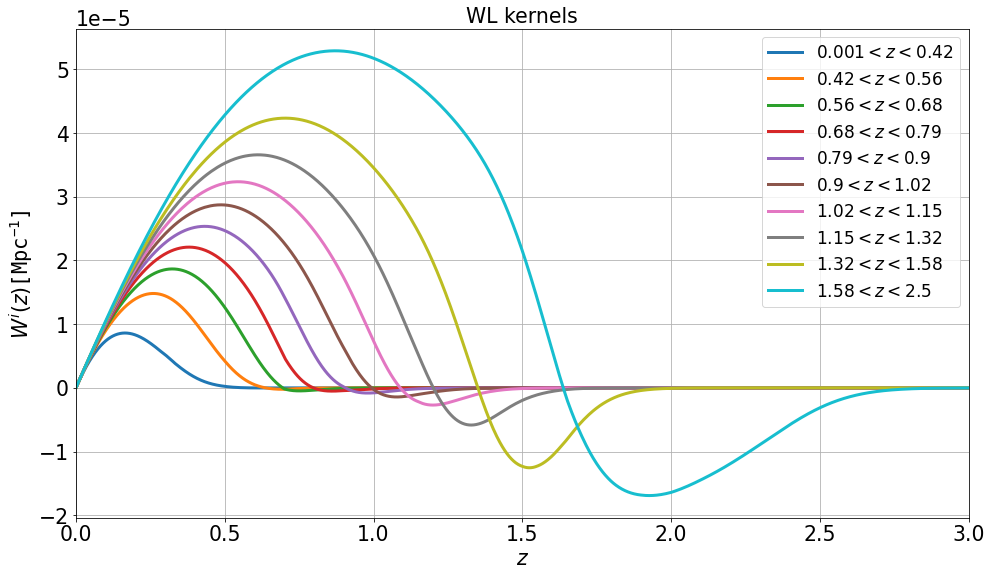

In [71]:
wil = np.genfromtxt(path / f"inputs/WF/wil_dav_IA_IST_nz10000.txt")
wig = np.genfromtxt(path / f"inputs/WF/wig_dav_IST_nz10000.txt")

zbins = 10
z_edges = [0.0010, 0.42, 0.56, 0.68, 0.79, 0.90, 1.02, 1.15, 1.32, 1.58, 2.50]

# lensing
for i in range(zbins):
    plt.plot(wil[:,0], wil[:,i+1], label = f'${z_edges[i]} < z < {z_edges[i+1]}$')
plt.grid()
plt.xlim((0,3))
#plt.legend(bbox_to_anchor=[1, 0.3])
plt.legend()

plt.xlabel('$z$')
plt.ylabel('$W^i(z) \\tt{[Mpc^{-1}]}$')
plt.title('WL kernels')

Text(0.5, 1.0, 'GCph kernels')

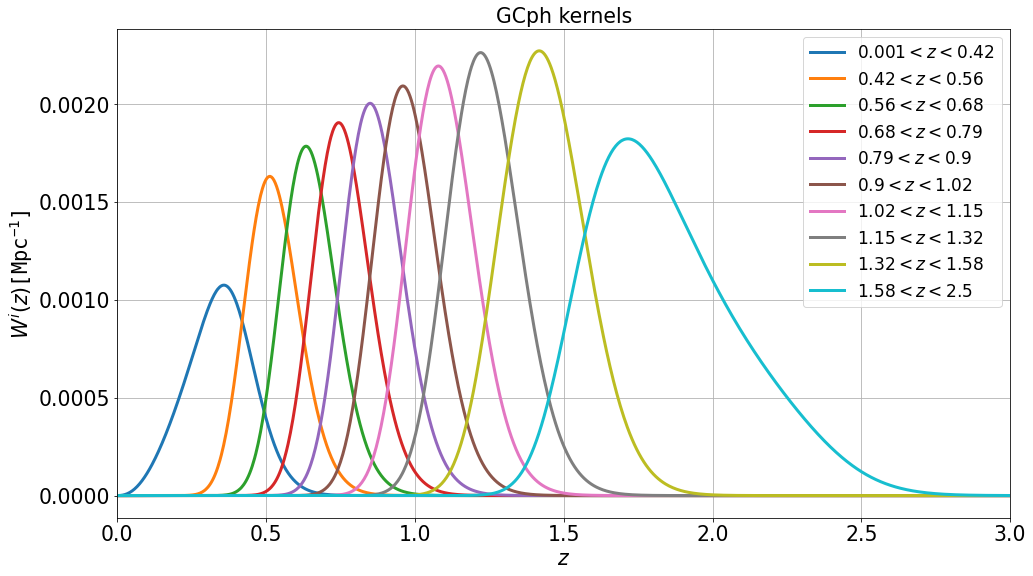

In [72]:
# GCph
for i in range(zbins):
    plt.plot(wig[:,0], wig[:,i+1], label = f'${z_edges[i]} < z < {z_edges[i+1]}$')
plt.grid()
#plt.legend(bbox_to_anchor=[1, 0.3])
plt.legend()

plt.xlim((0,3))
plt.xlabel('$z$')
plt.ylabel('$W^i(z) \\tt{[Mpc^{-1}]}$')
plt.title('GCph kernels')

### <span style="color:red">convention</span>

Possibility to specify the convention used in the latest version of the code. In general, we have:

$$W_{\mathrm{PySSC}}^{\mathrm{GC}}(z) = W_{\text {IST:F}}^{\mathrm{GC}}(z) \big / \chi^{2}$$ \
$$W_{\mathrm{PySSC}}^{\mathrm{WL}}(z) = W_{\mathrm{IST:F}}^{WL}(z) \big / \chi^{2} $$

In [20]:
fileName = f"Sijkl_WFdavide_nz10000_IA_demo.npy"
print('WF shape:', wil.shape, '(z points, z bins + 1)')

WF shape: (10000, 11) (z points, z bins + 1)


### <span style="color:red">high number of points</span> in redshift grid

In [21]:
# set the redshift array, z_arr
z_arr = wil[:,0]
print('number of points in the z grid:', z_arr.shape[0])

number of points in the z grid: 10000


In [22]:
# delete the redshift column (0-th column):
wil = np.delete(wil, 0, axis=1)
wig = np.delete(wig, 0, axis=1)
print('WF shape:', wil.shape)

WF shape: (10000, 10)


In [23]:
# transpose
wil = np.transpose(wil)
wig = np.transpose(wig)

# vertically stack the WFs (row-wise, wil first, wig second)
w = np.vstack((wil, wig))
windows = w
print('WF shape:', windows.shape)

WF shape: (20, 10000)


### Compute $S_{ijkl}$ (the Jupyter kernel freezes, loading the already computed Sijkl array insted:)

In [77]:
# call the routine

# convention = 0 is PySSC
# convention = 1 is IST:F

# start_time = time.time()
# Sijkl = PySSC.Sijkl(z_arr, windows, cosmo_params = cosmo_params_dict, precision=10, tol=1e-3, convention=1)

# print("Sijkl matrix computed in %.1f seconds" %(time.time() - start_time))
# np.save(f"{path}/output/Sijkl/{fileName}", Sijkl)

In [74]:
print('Sijkl computation time for 3x2pt: around 110 seconds')
Sijkl = np.load(path / f"outputs/Sijkl/Sijkl_WFdavide_nz10000_IA_3may.npy")
print('Sikjl shape:', Sijkl.shape, '= (2*nzbins, 2*nzbins, 2*nzbins, 2*nzbins)')

Sijkl computation time for 3x2pt: around 110 seconds
Sikjl shape: (20, 20, 20, 20) = (2*nzbins, 2*nzbins, 2*nzbins, 2*nzbins)


### Recast Sijkl as a matrix of pairs

bins far enough apart have basically no overlap so the cross-spectra is zero. If the overlap is small enough (<0.1% by default), the code sets Sijkl to zero
(white areas)


/var/folders/l4/w0t4jccj3ys27bbg1y8nwdk00000gn/T/ipykernel_87627/2821665857.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.matshow(np.log10(np.abs(Sijkl_2D)))


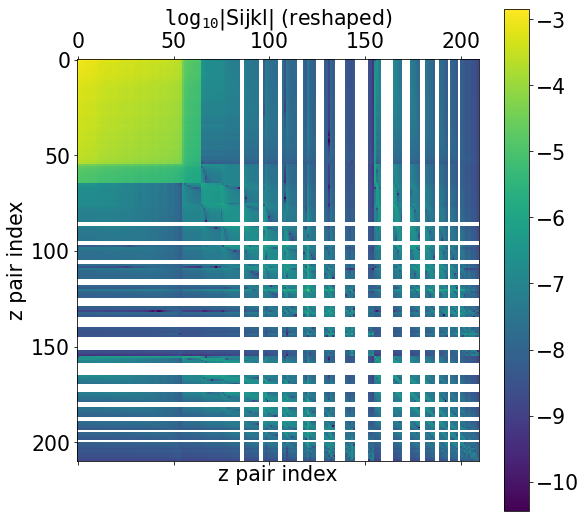

In [75]:
Sijkl_2D =  mm.Recast_Sijkl_3x2pt(Sijkl, zbins)[0]  # Function taken by Fabien's GitHub notebooks
plt.matshow(np.log10(np.abs(Sijkl_2D)))
plt.colorbar()
plt.title("$\\tt{log_{10}}$|Sijkl| (reshaped)")
plt.xlabel("z pair index")
plt.ylabel("z pair index")

print('bins far enough apart have basically no overlap so the cross-spectra is zero. '
      'If the overlap is small enough (<0.1% by default), the code sets Sijkl to zero\n'
      '(white areas)')

## Step 2.2: compute SSC and G+SSC covariance matrices 

$$    Cov_{SSC}[C^{AB}_{ij}(\ell),C^{CD}_{kl}(\ell ')] \simeq R^{AB}(\ell)C^{AB}_{ij}(\ell)R^{CD}(\ell)C^{CD}_{kl}(\ell ')S^{A,B;C,D}_{i,j;k,l} \times f_{sky}^{-1} $$

__How to unpack the $S_{ijkl}$ matrix:__
<br>
$S^{A,B;C,D}_{i,j;k,l} $ 


$\downarrow $


`S[i,j,k,l]`

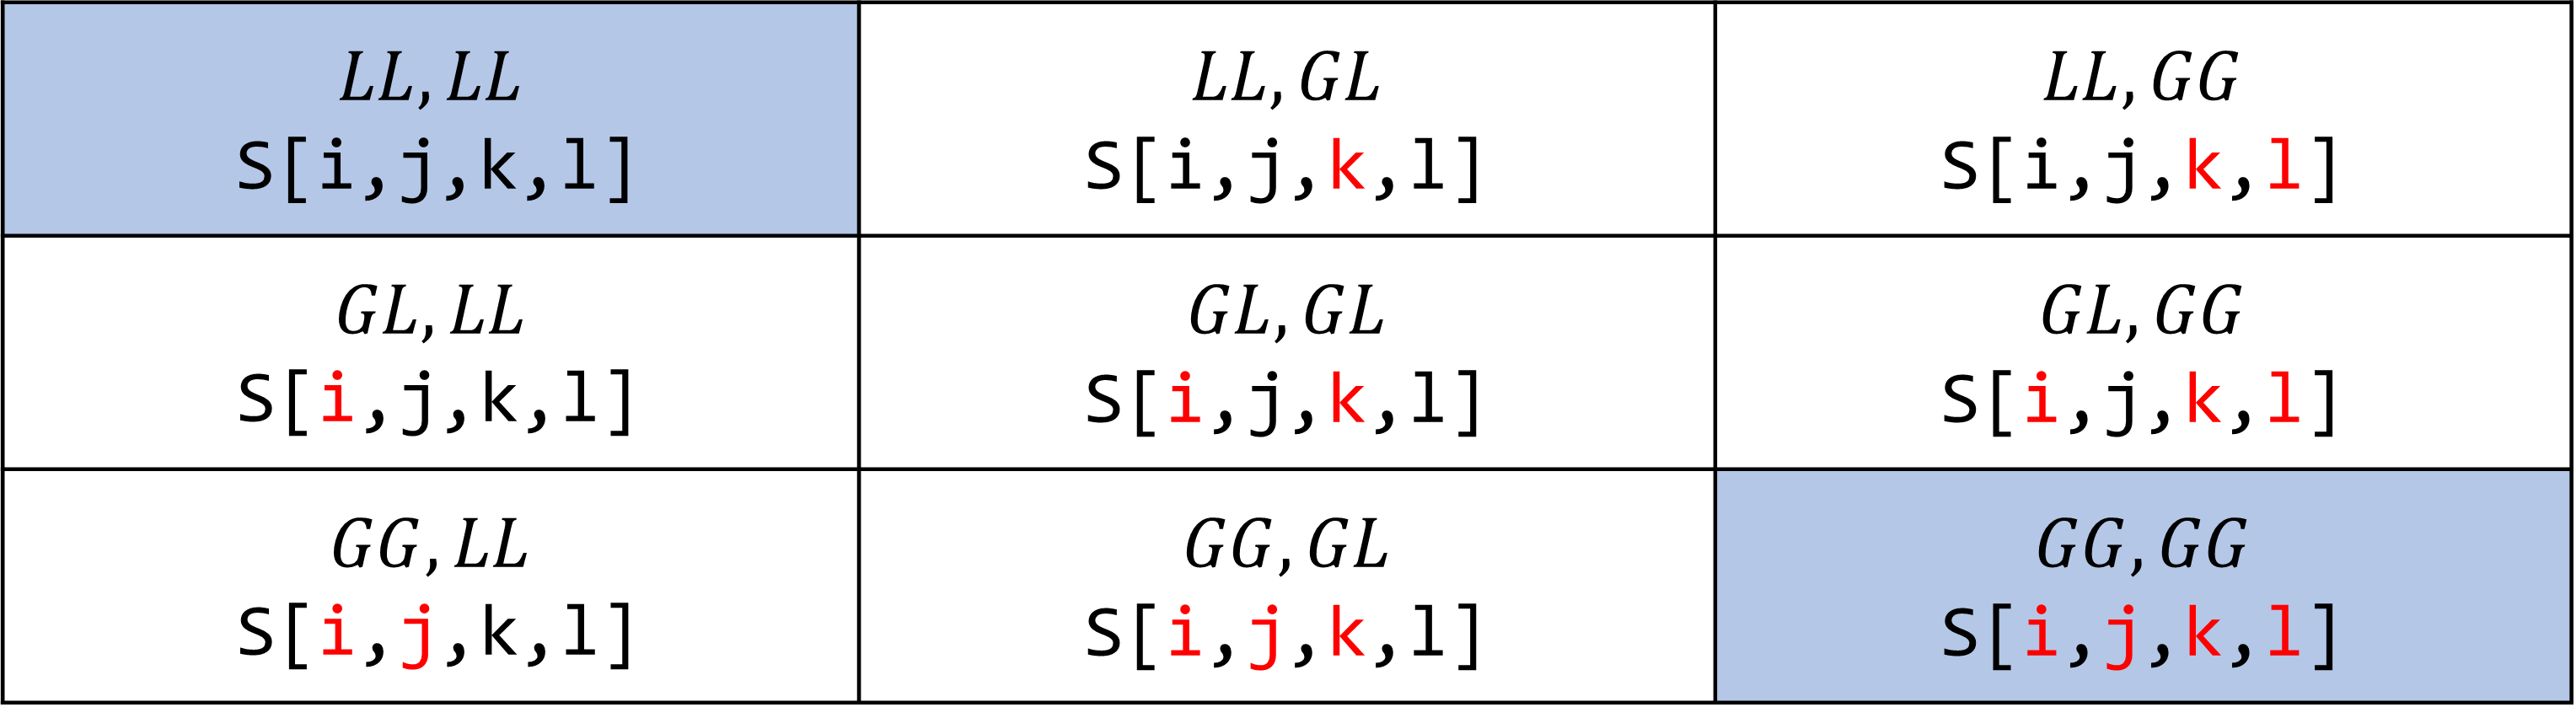

### with <font color='red'>i</font> = i + zbins
**blue blocks are for WL only and GCph only**

### Function for 3x2pt (again, massive speedup with  `@jit`)


In [25]:
# a more elegant version, making use of dictionaries, is available in the library ('cov_SSC_3x2pt_10D_dict'); however, using jit this implementation is faster.

@jit(nopython=True)
def cov_SSC_ALL(nbl, npairs_tot, ind, D_ALL, Sijkl, fsky, zbins, Rl):
    
    cov_ALL_SSC = np.zeros((nbl, nbl, npairs_tot, npairs_tot))
    for ell1 in range(nbl):
        for ell2 in range(nbl):
            for p in range (npairs_tot):
                for q in range (npairs_tot):
                    #LL_LL
                    if ind[p,0] == 0 and ind[p,1] == 0 and ind[q,0] == 0 and ind[q,1] == 0:
                        cov_ALL_SSC[ell1,ell2,p,q] = (Rl*Rl*\
                        D_ALL[ell1, ind[p,0], ind[p,1], ind[p,2], ind[p,3]]*\
                        D_ALL[ell2, ind[q,0], ind[q,1], ind[q,2], ind[q,3]]*\
                        Sijkl[ind[p,2],ind[p,3],ind[q,2],ind[q,3]])
                    #LL_GL
                    elif ind[p,0] == 0 and ind[p,1] == 0 and ind[q,0] == 1 and ind[q,1] == 0:
                        cov_ALL_SSC[ell1,ell2,p,q] = (Rl*Rl*\
                        D_ALL[ell1, ind[p,0], ind[p,1], ind[p,2], ind[p,3]]*\
                        D_ALL[ell2, ind[q,0], ind[q,1], ind[q,2], ind[q,3]]*\
                        Sijkl[ind[p,2],ind[p,3],ind[q,2]+zbins,ind[q,3]])
                    #LL_GG
                    elif ind[p,0] == 0 and ind[p,1] == 0 and ind[q,0] == 1 and ind[q,1] == 1:
                        cov_ALL_SSC[ell1,ell2,p,q] = (Rl*Rl*\
                        D_ALL[ell1, ind[p,0], ind[p,1], ind[p,2], ind[p,3]]*\
                        D_ALL[ell2, ind[q,0], ind[q,1], ind[q,2], ind[q,3]]*\
                        Sijkl[ind[p,2],ind[p,3],ind[q,2]+zbins,ind[q,3]+zbins])
            
                    #GL_LL
                    elif ind[p,0] == 1 and ind[p,1] == 0 and ind[q,0] == 0 and ind[q,1] == 0:
                        cov_ALL_SSC[ell1,ell2,p,q] = (Rl*Rl*\
                        D_ALL[ell1, ind[p,0], ind[p,1], ind[p,2], ind[p,3]]*\
                        D_ALL[ell2, ind[q,0], ind[q,1], ind[q,2], ind[q,3]]*\
                        Sijkl[ind[p,2]+zbins,ind[p,3],ind[q,2],ind[q,3]])
                    #GL_GL
                    elif ind[p,0] == 1 and ind[p,1] == 0 and ind[q,0] == 1 and ind[q,1] == 0:
                        cov_ALL_SSC[ell1,ell2,p,q] = (Rl*Rl*\
                        D_ALL[ell1, ind[p,0], ind[p,1], ind[p,2], ind[p,3]]*\
                        D_ALL[ell2, ind[q,0], ind[q,1], ind[q,2], ind[q,3]]*\
                        Sijkl[ind[p,2]+zbins,ind[p,3],ind[q,2]+zbins,ind[q,3]])
                    #GL_GG
                    elif ind[p,0] == 1 and ind[p,1] == 0 and ind[q,0] == 1 and ind[q,1] == 1:
                        cov_ALL_SSC[ell1,ell2,p,q] = (Rl*Rl*\
                        D_ALL[ell1, ind[p,0], ind[p,1], ind[p,2], ind[p,3]]*\
                        D_ALL[ell2, ind[q,0], ind[q,1], ind[q,2], ind[q,3]]*\
                        Sijkl[ind[p,2]+zbins,ind[p,3],ind[q,2]+zbins,ind[q,3]+zbins])
            
                    #GG_LL
                    elif ind[p,0] == 1 and ind[p,1] == 1 and ind[q,0] == 0 and ind[q,1] == 0:
                        cov_ALL_SSC[ell1,ell2,p,q] = (Rl*Rl*\
                        D_ALL[ell1, ind[p,0], ind[p,1], ind[p,2], ind[p,3]]*\
                        D_ALL[ell2, ind[q,0], ind[q,1], ind[q,2], ind[q,3]]*\
                        Sijkl[ind[p,2]+zbins,ind[p,3]+zbins,ind[q,2],ind[q,3]])
                    #GG_GL
                    elif ind[p,0] == 1 and ind[p,1] == 1 and ind[q,0] == 1 and ind[q,1] == 0:
                        cov_ALL_SSC[ell1,ell2,p,q] = (Rl*Rl*\
                        D_ALL[ell1, ind[p,0], ind[p,1], ind[p,2], ind[p,3]]*\
                        D_ALL[ell2, ind[q,0], ind[q,1], ind[q,2], ind[q,3]]*\
                        Sijkl[ind[p,2]+zbins,ind[p,3]+zbins,ind[q,2]+zbins,ind[q,3]])
                    #GG_GG
                    elif ind[p,0] == 1 and ind[p,1] == 1 and ind[q,0] == 1 and ind[q,1] == 1:
                        cov_ALL_SSC[ell1,ell2,p,q] = (Rl*Rl*\
                        D_ALL[ell1, ind[p,0], ind[p,1], ind[p,2], ind[p,3]]*\
                        D_ALL[ell2, ind[q,0], ind[q,1], ind[q,2], ind[q,3]]*\
                        Sijkl[ind[p,2]+zbins,ind[p,3]+zbins,ind[q,2]+zbins,ind[q,3]+zbins])
                        
    cov_ALL_SSC /= fsky
    return cov_ALL_SSC

Actual implementation:

In [47]:
Rl = my_config.Rl # probe response
start_time = time.time()

cov_WL_SSC  = mm.cov_SSC(nbl,    npairs, ind, C_LL, Sijkl, fsky, "WL", zbins, Rl)
cov_GC_SSC  = mm.cov_SSC(nbl,    npairs, ind, C_GG, Sijkl, fsky, "GC", zbins, Rl)
cov_WA_SSC  = mm.cov_SSC(nbl_WA, npairs, ind, C_WA, Sijkl, fsky, "WA", zbins, Rl)
cov_ALL_SSC = mm.cov_SSC_ALL(nbl, npairs_tot, ind, D_ALL, Sijkl, fsky, zbins, Rl)

########### ADDING Gauss-only + SSC #####################

# sum Gauss + SSC
cov_WL_tot  = cov_WL_Gauss + cov_WL_SSC # WLonly
cov_GC_tot  = cov_GC_Gauss + cov_GC_SSC # GConly
cov_ALL_tot = cov_ALL_Gauss + cov_ALL_SSC # ALL
cov_WA_tot  = cov_WA_Gauss + cov_WA_SSC # WA

# reduce dimensions: 4D to 2D
cov_WL_tot_2D = mm.cov_4D_to_2D(cov_WL_tot, nbl, npairs)
cov_WL_SSC_2D = mm.cov_4D_to_2D(cov_WL_SSC, nbl, npairs)
cov_GC_tot_2D = mm.cov_4D_to_2D(cov_GC_tot, nbl, npairs)
cov_GC_SSC_2D = mm.cov_4D_to_2D(cov_GC_SSC, nbl, npairs)
cov_ALL_tot_2D = mm.cov_4D_to_2D(cov_ALL_tot, nbl, npairs_tot)
cov_ALL_SSC_2D = mm.cov_4D_to_2D(cov_ALL_SSC, nbl, npairs_tot)
cov_WA_tot_2D = mm.cov_4D_to_2D(cov_WA_tot, nbl_WA, npairs)
cov_WA_SSC_2D = mm.cov_4D_to_2D(cov_WA_SSC, nbl_WA, npairs)


print("Gaussian+SSC covariance matrices computed in %.2f seconds" %(time.time() - start_time))

Gaussian+SSC covariance matrices computed in 0.87 seconds


### Save matrices (npy, dat or txt)

In [48]:
# save SSC only in npy
# np.save(f"{path}/output/covmat/WL_SSC/covmatSSC_WLonly_lmin10_lmaxWL{ell_max_WL}_nbl{nbl}.npy" , cov_WL_SSC_2D)
# np.save(f"{path}/output/covmat/GC_SSC/covmatSSC_GConly_lmin10_lmaxGC{ell_max_GC}_nbl{nbl}.npy" , cov_GC_SSC_2D)
# np.save(f"{path}/output/covmat/ALL_SSC/covmatSSC_ALL_lmin10_lmaxXC{ell_max_XC}_nbl{nbl}.npy" ,   cov_ALL_SSC_2D)
# np.save(f"{path}/output/covmat/ALL_SSC/covmatSSC_WA_lmin10_lmaxWL{ell_max_WL}_nbl{nbl}.npy" ,    cov_WA_SSC_2D)

# save Gauss + SSC ("tot") in npy
np.save(path / f"outputs/covmat/covmat_GS_WL_lmaxWL{ell_max_WL}_nbl{nbl}.npy" , cov_WL_tot_2D)
np.save(path / f"outputs/covmat/covmat_GS_GC_lmaxGC{ell_max_GC}_nbl{nbl}.npy" , cov_GC_tot_2D)
np.save(path / f"outputs/covmat/covmat_GS_ALL_lmaxXC{ell_max_XC}_nbl{nbl}.npy" ,   cov_ALL_tot_2D)
np.save(path / f"outputs/covmat/covmat_GS_WA_lmaxWL{ell_max_WL}_nbl{nbl}.npy" ,    cov_WA_tot_2D)
print('saved')

saved


/var/folders/l4/w0t4jccj3ys27bbg1y8nwdk00000gn/T/ipykernel_87627/317928325.py:3: RuntimeWarning: divide by zero encountered in log10
  G     = ax1.matshow(np.log10(mm.cov_4D_to_2D(cov_ALL_Gauss, nbl, npairs_tot)))
/var/folders/l4/w0t4jccj3ys27bbg1y8nwdk00000gn/T/ipykernel_87627/317928325.py:3: RuntimeWarning: invalid value encountered in log10
  G     = ax1.matshow(np.log10(mm.cov_4D_to_2D(cov_ALL_Gauss, nbl, npairs_tot)))
/var/folders/l4/w0t4jccj3ys27bbg1y8nwdk00000gn/T/ipykernel_87627/317928325.py:4: RuntimeWarning: divide by zero encountered in log10
  G_SSC = ax2.matshow(np.log10(mm.cov_4D_to_2D(cov_ALL_tot, nbl, npairs_tot)))
/var/folders/l4/w0t4jccj3ys27bbg1y8nwdk00000gn/T/ipykernel_87627/317928325.py:4: RuntimeWarning: invalid value encountered in log10
  G_SSC = ax2.matshow(np.log10(mm.cov_4D_to_2D(cov_ALL_tot, nbl, npairs_tot)))


Text(0.5, 0.98, '3x2pt covariance matrices')

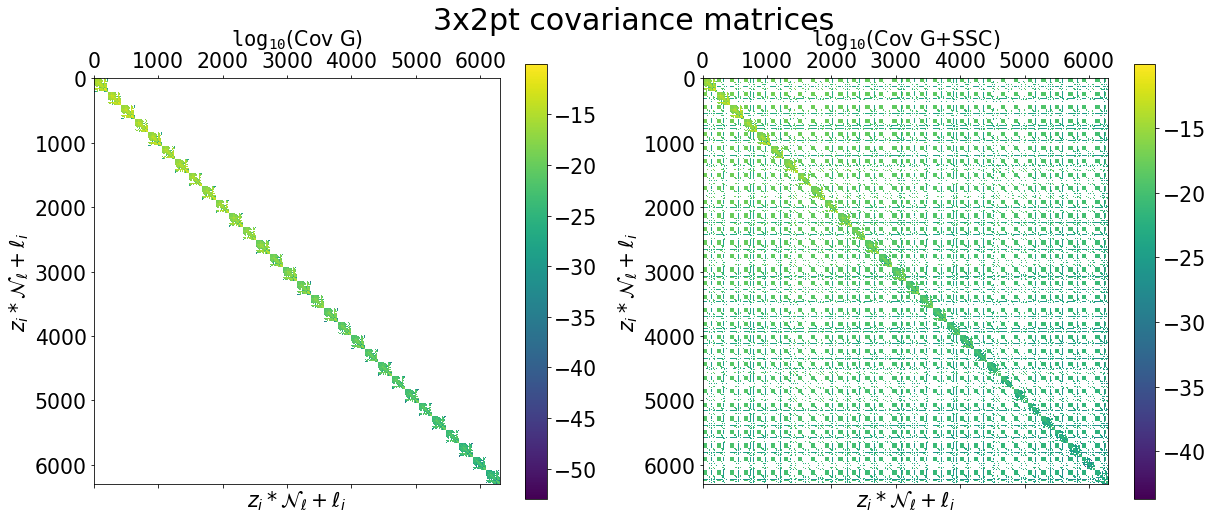

In [49]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))

G     = ax1.matshow(np.log10(mm.cov_4D_to_2D(cov_ALL_Gauss, nbl, npairs_tot)))
G_SSC = ax2.matshow(np.log10(mm.cov_4D_to_2D(cov_ALL_tot, nbl, npairs_tot)))

ax1.set_title('$\\tt{log_{10}}$(Cov G)')
ax2.set_title('$\\tt{log_{10}}$(Cov G+SSC)')

label = r'$z_i*\mathcal{N}_\ell + \ell_i$'
ax1.set_xlabel(label)
ax1.set_ylabel(label)
ax2.set_xlabel(label)
ax2.set_ylabel(label)

plt.colorbar(G, ax=ax1)
plt.colorbar(G_SSC, ax=ax2)
fig.suptitle('3x2pt covariance matrices', fontsize=30)

Full SSC:
$$Cov_{SSC}(\mathcal{O}_1,\mathcal{O}_2) = \int \int
\text d V_1\text d V_2 \dfrac{\partial \rho_1}{\partial \delta_b} (z_1) \dfrac{\partial \rho_2}{\partial \delta_b} (z_2) \sigma^2(z_1,z_2)$$
with $\rho_i$ comoving density of the observable $i$ (GCph or WL)